In [2]:
!apt install cuda

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  cuda-11-5 cuda-cccl-11-5 cuda-command-line-tools-11-5 cuda-compiler-11-5
  cuda-cudart-11-5 cuda-cudart-dev-11-5 cuda-cuobjdump-11-5 cuda-cupti-11-5
  cuda-cupti-dev-11-5 cuda-cuxxfilt-11-5 cuda-demo-suite-11-5
  cuda-documentation-11-5 cuda-driver-dev-11-5 cuda-gdb-11-5
  cuda-libraries-11-5 cuda-libraries-dev-11-5 cuda-memcheck-11-5
  cuda-nsight-11-5 cuda-nsight-compute-11-5 cuda-nsight-systems-11-5
  cuda-nvcc-11-5 cuda-nvdisasm-11-5 cuda-nvml-dev-11-5 cuda-nvprof-11-5
  cuda-nvprune-11-5 cuda-nvrtc-11-5 cuda-nvrtc-dev-11-5 cuda-nvtx-11-5
  cuda-nvvp-11-5 cuda-runtime-11-5 cuda-samples-11-5 cuda-sanitizer-11-5
  cuda-toolkit-11-5 cuda-toolkit-11-5-config-common
  cuda-toolkit-11-config-common cuda-toolkit-config-common cuda-tools-11-5
  cuda-visual-tools-11-5 gds-tools-11-5 libcublas-11-5 libcublas-dev-11-5
  libcufft-11-5 libcufft-d

In [3]:
!pip install mxnet-cu101

     |████████████████████████████████| 358.1 MB 5.0 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [4]:
import os
import json
import zipfile
import time
import itertools

import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

import numpy as np
import mxnet as mx
import multiprocessing as mp

from mxnet import gluon, nd, init, autograd
from mxnet.gluon import nn, rnn

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import random

import math
import pdb

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# iUse sklearn's metric function to evaluate the results of the experiment
from sklearn.metrics import accuracy_score, f1_score

warnings.filterwarnings('ignore')

# fixed random number seed
np.random.seed(2018)
mx.random.seed(2018)

def try_gpu():
    """If GPU is available, return mx.gpu(0); else return mx.cpu()."""
    try:
        ctx = mx.gpu()
        _ = nd.array([0], ctx=ctx)
    except:
        ctx = mx.cpu()
    return ctx

In [5]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Jan 14 02:38:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
travel_time_df = pd.read_csv('/content/drive/MyDrive/CIS 545 Project Folder/Data Set/2021_travel_time.csv')
corridor_file = "/content/drive/MyDrive/CIS 545 Project Folder/Data Set/pems_district4_corridors.xlsx"
corridor_df = pd.read_excel(corridor_file)

travel_time_df = travel_time_df[travel_time_df['5 Minutes'] > '2021-1-01 00:00:00']

In [7]:
corridors_to_merge = []

for row_num, corridor in corridor_df.iterrows():  	
      if row_num == 0:
          all_corridors_tt_2021 = travel_time_df[(travel_time_df['corridor_name'] == corridor["Corridor"])	&  (travel_time_df['direction'] == corridor["Fwy-Dir"])][["5 Minutes",	"Mainline Agg"]]
      else:
          corridor_tt_2021 = travel_time_df[(travel_time_df['corridor_name'] == corridor["Corridor"])	&  (travel_time_df['direction'] == corridor["Fwy-Dir"])][["5 Minutes",	"Mainline Agg"]]
          all_corridors_tt_2021 = all_corridors_tt_2021.merge(corridor_tt_2021, "outer", left_on='5 Minutes', right_on='5 Minutes')

In [8]:
all_corridors_tt_2021

,5 Minutes,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,...,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y
0,2021-10-01 00:00:00,10.90,11.55,NaN,NaN,NaN,5.32,4.23,3.83,6.60,6.68,NaN,1.87,10.72,10.83,21.82,21.73,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,16.65,16.47,10.75,10.97,6.43,7.00,16.70,16.42,4.18,4.23,3.57,3.52,NaN,NaN,11.40,...,17.15,17.50,12.18,12.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.92,13.93,14.42,14.42,18.10,NaN,NaN,NaN,18.32,18.77,25.4,25.52,9.12,9.13,5.73,5.85,15.75,15.78,16.43,15.65,12.15,11.55,NaN,NaN
1,2021-10-01 00:00:00,10.90,11.55,NaN,NaN,NaN,5.32,4.23,3.83,6.60,6.68,NaN,1.87,10.72,10.83,21.82,21.73,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,16.65,16.47,10.75,10.97,6.43,7.00,16.70,16.42,4.18,4.23,3.57,3.52,NaN,NaN,11.40,...,17.15,17.50,12.18,12.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.92,13.93,14.42,14.42,18.10,NaN,NaN,NaN,18.32,18.77,25.4,25.52,9.12,9.13,5.73,5.85,15.75,15.78,16.43,15.65,12.15,11.55,NaN,NaN
2,2021-10-01 00:00:00,10.90,11.55,NaN,NaN,NaN,5.32,4.23,3.83,6.60,6.68,NaN,1.87,10.72,10.83,21.82,21.73,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,16.65,16.47,10.75,10.97,6.43,7.00,16.70,16.42,4.18,4.23,3.57,3.52,NaN,NaN,11.40,...,17.15,17.50,12.18,12.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.92,13.93,14.42,14.42,18.10,NaN,NaN,NaN,18.32,18.77,25.4,25.52,9.12,9.13,5.73,5.85,15.75,15.78,16.43,15.65,12.15,11.55,NaN,NaN
3,2021-10-01 00:00:00,10.90,11.55,NaN,NaN,NaN,5.32,4.23,3.83,6.60,6.68,NaN,1.87,10.72,10.83,21.82,21.73,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,16.65,16.47,10.75,10.97,6.43,7.00,16.70,16.42,4.18,4.23,3.57,3.52,NaN,NaN,11.40,...,17.15,17.50,12.18,12.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.92,13.93,14.42,14.42,18.10,NaN,NaN,NaN,18.32,18.77,25.4,25.52,9.12,9.13,5.73,5.85,15.75,15.78,16.43,15.65,12.15,11.55,NaN,NaN
4,2021-10-01 00:00:00,10.90,11.55,NaN,NaN,NaN,5.35,4.23,3.83,6.60,6.68,NaN,1.87,10.72,10.83,21.82,21.73,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,16.65,16.47,10.75,10.97,6.43,7.00,16.70,16.42,4.18,4.23,3.57,3.52,NaN,NaN,11.40,...,17.15,17.50,12.18,12.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.92,13.93,14.42,14.42,18.10,NaN,NaN,NaN,18.32,18.77,25.4,25.52,9.12,9.13,5.73,5.85,15.75,15.78,16.43,15.65,12.15,11.55,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55867,2021-10-31 23:55:00,10.88,11.60,NaN,NaN,NaN,5.33,3.93,3.85,6.58,6.73,NaN,1.87,10.78,10.60,21.62,21.37,4.12,4.08,1.25,1.32,12.98,14.45,6.17,7.58,16.75,16.45,10.78,10.95,6.43,7.02,16.57,16.53,4.12,4.25,3.57,3.52,NaN,NaN,10.83,...,17.18,17.52,12.40,12.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.95,13.97,15.32

In [9]:
all_corridors_tt_2021 = all_corridors_tt_2021.dropna(axis=1)
all_corridors_tt_2021

,5 Minutes,Mainline Agg_x,Mainline Agg_y,Mainline Agg_y,Mainline Agg_x,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_y,Mainline Agg_x,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_x,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y
0,2021-10-01 00:00:00,10.90,11.55,5.32,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.4,25.52,5.73,5.85,15.75,15.78
1,2021-10-01 00:00:00,10.90,11.55,5.32,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.4,25.52,5.73,5.85,15.75,15.78
2,2021-10-01 00:00:00,10.90,11.55,5.32,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.4,25.52,5.73,5.85,15.75,15.78
3,2021-10-01 00:00:00,10.90,11.55,5.32,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.4,25.52,5.73,5.85,15.75,15.78
4,2021-10-01 00:00:00,10.90,11.55,5.35,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.4,25.52,5.73,5.85,15.75,15.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55867,2021-10-31 23:55:00,10.88,11.60,5.33,10.78,4.12,4.08,1.25,1.32,12.98,14.45,6.17,7.58,4.12,4.25,3.57,3.52,27.42,11.87,11.78,12.05,7.77,17.98,15.05,3.30,3.25,12.42,12.20,8.03,8.15,17.18,12.40,13.95,13.97,18.42,18.82,25.7,25.53,5.73,5.92,15.70,15.72
55868,2021-10-31 23:55:00,10.88,11.60,5.33,10.78,4.12,4.08,1.25,1.32,12.98,14.45,6.17,7.58,4.12,4.25,3.57,3.52,27.42,11.87,11.78,12.05,7.77,17.98,15.05,3.30,3.25,12.42,12.20,8.03,8.15,17.18,12.40,13.95,13.97,18.42,18.82,25.7,25.53,5.73,5.92,15.70,15.72
55869,2021-10-31 23:55:00,10.88,11.60,5.33,10.78,4.12,4.08,1.25,1.32,12.98,14.45,6.17,7.58,4.12,4.25,3.57,3.52,27.42,11.87,11.78,12.05,7.77,17.98,15.05,3.30,3.25,12.42,12.20,8.03,8.15,17.18,12.40,13.95,13.97,18.42,18.82,25.7,25.53,5.73,5.92,15.70,15.72
55870,2021-10-31 23:55:00,10.88,11.60,5.33,10.78,4.12,4.08,1.25,1.32,12.98,14.45,6.17,7.58,4.12,4.25,3.57,3.52,27.42,11.87,11.78,12.05,7.77,17.98,15.05,3.30,3.25,12.42,12.20,8.03,8.15,17.18,12.40,13.95,13.97,18.42,18.82,25.7,25.53,5.73,5.92,15.70,15.72


In [10]:
new_columns = [f"travel_time_{n}" for n in range(len(all_corridors_tt_2021.columns) - 1)]
new_columns.insert(0, "timestamp")
# len(new_columns)
all_corridors_tt_2021 = all_corridors_tt_2021.set_axis(new_columns, axis=1, inplace=False)
num_records, num_corridors = all_corridors_tt_2021.shape

In [11]:
all_corridors_tt_2021.head(10)

,timestamp,travel_time_0,travel_time_1,travel_time_2,travel_time_3,travel_time_4,travel_time_5,travel_time_6,travel_time_7,travel_time_8,travel_time_9,travel_time_10,travel_time_11,travel_time_12,travel_time_13,travel_time_14,travel_time_15,travel_time_16,travel_time_17,travel_time_18,travel_time_19,travel_time_20,travel_time_21,travel_time_22,travel_time_23,travel_time_24,travel_time_25,travel_time_26,travel_time_27,travel_time_28,travel_time_29,travel_time_30,travel_time_31,travel_time_32,travel_time_33,travel_time_34,travel_time_35,travel_time_36,travel_time_37,travel_time_38,travel_time_39,travel_time_40
0,2021-10-01 00:00:00,10.9,11.55,5.32,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.40,25.52,5.73,5.85,15.75,15.78
1,2021-10-01 00:00:00,10.9,11.55,5.32,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.40,25.52,5.73,5.85,15.75,15.78
2,2021-10-01 00:00:00,10.9,11.55,5.32,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.40,25.52,5.73,5.85,15.75,15.78
3,2021-10-01 00:00:00,10.9,11.55,5.32,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.40,25.52,5.73,5.85,15.75,15.78
4,2021-10-01 00:00:00,10.9,11.55,5.35,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.40,25.52,5.73,5.85,15.75,15.78
5,2021-10-01 00:00:00,10.9,11.55,5.35,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.40,25.52,5.73,5.85,15.75,15.78
6,2021-10-01 00:00:00,10.9,11.55,5.35,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.40,25.52,5.73,5.85,15.75,15.78
7,2021-10-01 00:00:00,10.9,11.55,5.35,10.72,4.12,4.07,1.25,1.27,13.45,13.08,6.43,6.12,4.18,4.23,3.57,3.52,27.58,11.95,11.78,11.98,7.55,17.87,14.87,3.23,3.28,12.43,12.28,8.08,8.15,17.15,12.18,13.92,13.93,18.32,18.77,25.40,25.52,5.73,5.85,15.75,15.78
8,2021-10-01 00:05:00,10.9,11.58,5.32,10.62,4.15,4.23,1.28,1.25,13.38,13.05,6.47,6.08,4.22,4.63,3.57,3.57,27.75,11.93,11.98,12.02,7.62,17.98,14.83,3.22,3.30,12.43,12.33,8.28,8.20,17.13,12.17,13.92,13.93,18.33,18.78,25.48,25.58,5.75,6.08,15.70,15.80
9,2021-10-01 00:05:00,10.9,11.58,5.32,10.62,4.15,4.23,1.28,1.25,13.38,13.05,6.47,6.08,4.22,4.63,3.57,3.57,27.75,11.93,11.98,12.02,7.62,17.98,14.83,3.22,3.30,12.43,12.33,8.28,8.20,17.13,12.17,13.92,13.93,18.33,18.78,25.48,25.58,5.75,6.08,15.70,15.80


In [12]:
def make_dataset_many_to_one(array,time_steps, num_sample):

    x = []
    y = []

    indices = random.sample(range(time_steps, len(array)), num_sample)

    for i in indices:
        x.append(array[i-time_steps:i])
        y.append(array[i])
        
    return np.array(x), np.array(y)

# train_data = all_corridors_tt_2021.drop(['timestamp'], axis=1).iloc[:num_training]
total_data = all_corridors_tt_2021.drop(['timestamp'], axis=1)
 #for testing at bottom
print(total_data)

       travel_time_0  travel_time_1  ...  travel_time_39  travel_time_40
0              10.90          11.55  ...           15.75           15.78
1              10.90          11.55  ...           15.75           15.78
2              10.90          11.55  ...           15.75           15.78
3              10.90          11.55  ...           15.75           15.78
4              10.90          11.55  ...           15.75           15.78
...              ...            ...  ...             ...             ...
55867          10.88          11.60  ...           15.70           15.72
55868          10.88          11.60  ...           15.70           15.72
55869          10.88          11.60  ...           15.70           15.72
55870          10.88          11.60  ...           15.70           15.72
55871          10.88          11.60  ...           15.70           15.72

[55872 rows x 41 columns]


In [13]:
#scale values to [0,1]
num_training = 12000
num_validate = 4000
num_test = 4000
time_steps = 24  # 2 hours
num_corridor = total_data.shape[1]


scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit_transform(total_data)
# train = scaler.transform(train_data)
total = scaler.transform(total_data)

trn_x, trn_y = make_dataset_many_to_one(total, time_steps, num_training)  #every 2 hours.
print(trn_x.shape, trn_x.shape)
vld_x, vld_y = make_dataset_many_to_one(total, time_steps, num_validate)  #every 2 hours.
print(vld_x.shape, vld_y.shape)
tst_x, tst_y = make_dataset_many_to_one(total, time_steps, num_test)  #every 2 hours.

trn_x = trn_x.reshape(-1,time_steps, num_corridor)
vld_x = vld_x.reshape(-1,time_steps, num_corridor)
tst_x = tst_x.reshape(-1,time_steps, num_corridor)

# select = random.randrange(1, len(trn_x), 5)

# trn_x = trn_x[select]
# trn_y = trn_y[select]

(12000, 24, 41) (12000, 24, 41)
(4000, 24, 41) (4000, 41)


In [14]:
trn_x = mx.nd.array(trn_x)
trn_y = mx.nd.array(trn_y)

vld_x = mx.nd.array(vld_x)
vld_y = mx.nd.array(vld_y)

tst_x = mx.nd.array(tst_x)
tst_y = mx.nd.array(tst_y)

In [49]:
"""
Attention mechanism in Hierarchical LSTM
"""

class Lstm(nn.HybridBlock):

    def __init__(self, num_corridor, hidden_size, num_layers, nfc,
                 drop_prob, **kwargs): 
        super(Lstm, self).__init__(**kwargs)

        with self.name_scope():

            self.hidden_size = hidden_size
            self.num_layers = num_layers # default is 1

            # bottom layer of LSTM
            self.lstm = rnn.LSTM(hidden_size, num_layers = self.num_layers, dropout=0.2)                   

            self.dense = nn.Dense(nfc, activation='relu')
            self.output_layer = nn.Dense(num_corridor)
            self.drop_prob = drop_prob

    def hybrid_forward(self, F, inp):

        # input shape: [batch_size, seq_len, num_corridor]
        # bot_lstm_out: [seq_len, batch_size, num_hidden]  
        lstm_out = self.lstm(F.transpose(inp, axes=(1, 0, 2)))  # output, (hidden, cell) = lstm(input_data, begin_state)
        flattern_out = F.flatten(F.transpose(lstm_out, axes=(1, 0, 2)))
        dense_out = self.dense(F.Dropout(flattern_out, self.drop_prob))
        output = self.output_layer(F.Dropout(dense_out, self.drop_prob))

        return output

In [54]:
num_corridor =  total_data.shape[1]       # number of corridors also the channel in NTC
nhidden = 120        # lstm hidden_dim
nlayers = 2         # lstm layers
nfc = 512            # fully connected layer for attention
drop_prob = 0.5

model = Lstm(num_corridor, nhidden, nlayers, nfc, drop_prob)

device = mx.gpu(0) if mx.context.num_gpus() > 0 else mx.cpu(0)
model.initialize(mx.init.Xavier(), ctx=device)
model.hybridize()

In [55]:
trainer = gluon.Trainer(
    params=model.collect_params(),
    optimizer='adam',
    optimizer_params={'learning_rate': 0.001},
)

loss_function = gluon.loss.L2Loss()
mse = mx.metric.MSE()

In [56]:
EPOCHS = 1000
batch_size = 50

trn_loss, val_loss = [], []

train_iter = mx.io.NDArrayIter(trn_x, trn_y, batch_size, shuffle=True)
vld_iter = mx.io.NDArrayIter(vld_x, vld_y, batch_size, shuffle=True)

start = time.time()

for epoch in range(EPOCHS):
    
    for trn_batch in train_iter:

        x = trn_batch.data[0].as_in_context(device)
        y = trn_batch.label[0].as_in_context(device)
        
        with autograd.record():
            y_pred = model(x)
            loss = loss_function(y_pred, y)
        
        #backprop
        loss.backward()
        
        #Optimize!
        trainer.step(batch_size=trn_x.shape[0])
        
    train_iter.reset()
    
    # Calculate train metrics
    
    predictions = model(trn_x.as_in_context(device))
    mse.update(trn_y, predictions)
    trn_loss.append(mse.get()[1])
    mse.reset()

    # calculate valid metrics
    predictions = model(vld_x.as_in_context(device))
    mse.update(vld_y, predictions)
    val_loss.append(mse.get()[1])
    mse.reset()
    
    train_iter.reset()
    if (epoch + 1) % 10 == 0:
        print("epoch: {} | trn_loss: {:.8f} val_loss: {:.8f} ".format(epoch+1, trn_loss[-1], val_loss[-1]))
    
print("*"*100)

end = time.time()
print('time %.2f sec' % (end-start))

epoch: 10 | trn_loss: 0.00051521 val_loss: 0.00050974 
epoch: 20 | trn_loss: 0.00044578 val_loss: 0.00044436 
epoch: 30 | trn_loss: 0.00035719 val_loss: 0.00036231 
epoch: 40 | trn_loss: 0.00031282 val_loss: 0.00032207 
epoch: 50 | trn_loss: 0.00028381 val_loss: 0.00029095 
epoch: 60 | trn_loss: 0.00030925 val_loss: 0.00031864 
epoch: 70 | trn_loss: 0.00028141 val_loss: 0.00028987 
epoch: 80 | trn_loss: 0.00026689 val_loss: 0.00027931 
epoch: 90 | trn_loss: 0.00023984 val_loss: 0.00024966 
epoch: 100 | trn_loss: 0.00029118 val_loss: 0.00030198 
epoch: 110 | trn_loss: 0.00023161 val_loss: 0.00023832 
epoch: 120 | trn_loss: 0.00023265 val_loss: 0.00024149 
epoch: 130 | trn_loss: 0.00022909 val_loss: 0.00024153 
epoch: 140 | trn_loss: 0.00022785 val_loss: 0.00023737 
epoch: 150 | trn_loss: 0.00022768 val_loss: 0.00023878 
epoch: 160 | trn_loss: 0.00025098 val_loss: 0.00026365 
epoch: 170 | trn_loss: 0.00020451 val_loss: 0.00021488 
epoch: 180 | trn_loss: 0.00022188 val_loss: 0.00023014 
e

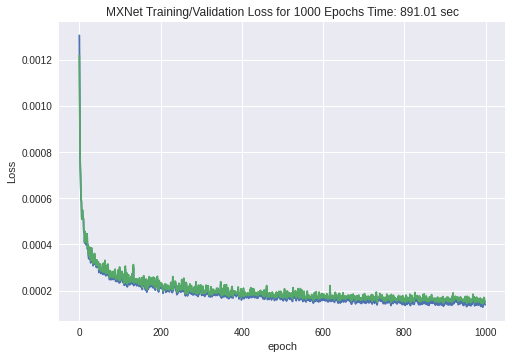

In [60]:
plt.plot(trn_loss, label = "Training Loss")
plt.plot(val_loss, label = "Validating Loss")
plt.title(f'MXNet Training/Validation Loss for {EPOCHS} Epochs Time: {round(end-start, 2)} sec')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()